###  Класифікація датасету FashionMNIST використавши Conv шари

Conv шари (Convolutional Layers) – це основні будівельні блоки в Convolutional Neural Networks (CNN), які використовуються для обробки зображень та інших даних з локальними залежностями. Вони застосовують фільтри (kernels) для виконання згортки над вхідними даними, виявляючи важливі особливості, такі як контури, текстури або складніші патерни. Завдяки цьому модель може навчатися ієрархії ознак, починаючи з простих елементів на початкових шарах і переходячи до більш абстрактних на глибших.

![Convolution Example](cnn-800.png)

1. **Input:** Вхідне зображення представлено у вигляді матриці пікселів.
2. **Image Patch:** Маленька ділянка (локальне вікно) зображення обробляється одночасно, це називається "local receptive field".
3. **Kernel (фільтр):** Фільтр (розміром 3x3 у цьому випадку) застосовується до цього вікна через операцію згортки. Елементи фільтра множаться на відповідні значення пікселів у "вікні" та сумуються.
4. **Output:** Результат записується у вихідну матрицю як одне значення (31 на малюнку).

### Операція згортки (оператор зірочки, дуже важлива штука)

На зображені дві матриці оброблються таким чином: (1⋅1)+(0⋅2)+(1⋅3)+(0⋅4)+(1⋅5)+(1⋅6)+(1⋅7)+(0⋅8)+(1⋅9)=31
Це і є згортка.

Згортка дозволяє моделі витягувати ознаки з локальних ділянок зображення (наприклад, контури, текстури). Це ефективно зменшує розмір зображення і зберігає важливу інформацію для подальшого навчання.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Перевірка наявності GPU. На усякий випадок. Раптом є.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cpu


In [4]:
# Завантаження датасету з перетвореннями
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


In [7]:
# Визначення моделі нейронної мережі
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # 1 канал, 6 фільтрів, 5x5 розмір фільтра
        self.pool = nn.MaxPool2d(2, 2)              # Пулінг 2x2
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)       # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)                # 10 класів

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Пулінг 2x2 
Пулінг 2x2  – це операція зменшення розмірності зображення або Feature Map, яка використовується після Conv-шарів у згорткових нейронних мережах (CNN).
1. 2x2 – означає, що локальне вікно (підматриця) розміром 2x2 береться із вхідної матриці.
2. Пулінг застосовується до кожного такого вікна для зменшення розміру матриці.

**Два найпоширеніші види пулінгу:**
- **Max Pooling:** обирається максимальне значення з кожного 2x2 вікна.
- **Average Pooling:** обчислюється середнє значення для кожного 2x2 вікна.


\begin{bmatrix}
1 & 3 & 2 & 1 \\
4 & 6 & 5 & 3 \\
7 & 8 & 2 & 4 \\
3 & 5 & 1 & 6
\end{bmatrix}

Розбиваємо матрицю на неперекривні вікна 2x2:

\begin{bmatrix}
1 & 3 \\
4 & 6
\end{bmatrix}

\begin{bmatrix}
2 & 1 \\
5 & 3
\end{bmatrix}

\begin{bmatrix}
7 & 8 \\
3 & 5
\end{bmatrix}

\begin{bmatrix}
2 & 4 \\
1 & 6
\end{bmatrix}

Застосовуємо Max Pooling (беремо максимальне значення у кожному вікні):

\begin{bmatrix}
6 & 8 \\
5 & 6
\end{bmatrix}



In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Тренування моделі
for epoch in range(5):  # кількість епох
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Training Finished')


[Epoch 1, Batch 100] loss: 2.304
[Epoch 1, Batch 200] loss: 2.297
[Epoch 1, Batch 300] loss: 2.290
[Epoch 1, Batch 400] loss: 2.277
[Epoch 1, Batch 500] loss: 2.245
[Epoch 1, Batch 600] loss: 2.132
[Epoch 1, Batch 700] loss: 1.677
[Epoch 1, Batch 800] loss: 1.116
[Epoch 1, Batch 900] loss: 0.903
[Epoch 2, Batch 100] loss: 0.793
[Epoch 2, Batch 200] loss: 0.791
[Epoch 2, Batch 300] loss: 0.758
[Epoch 2, Batch 400] loss: 0.744
[Epoch 2, Batch 500] loss: 0.699
[Epoch 2, Batch 600] loss: 0.678
[Epoch 2, Batch 700] loss: 0.678
[Epoch 2, Batch 800] loss: 0.667
[Epoch 2, Batch 900] loss: 0.667
[Epoch 3, Batch 100] loss: 0.621
[Epoch 3, Batch 200] loss: 0.648
[Epoch 3, Batch 300] loss: 0.613
[Epoch 3, Batch 400] loss: 0.611
[Epoch 3, Batch 500] loss: 0.605
[Epoch 3, Batch 600] loss: 0.578
[Epoch 3, Batch 700] loss: 0.601
[Epoch 3, Batch 800] loss: 0.597
[Epoch 3, Batch 900] loss: 0.582
[Epoch 4, Batch 100] loss: 0.583
[Epoch 4, Batch 200] loss: 0.542
[Epoch 4, Batch 300] loss: 0.534
[Epoch 4, 

In [9]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')


Accuracy of the network on the 10000 test images: 81.98%


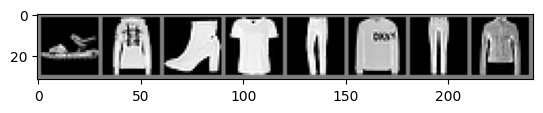

Sandal, Pullover, Ankle boot, T-shirt/top, Trouser, Pullover, Trouser, Coat


In [11]:
# Функція для показу зображень
def imshow(img):
    img = img / 2 + 0.5  # денормалізація
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()

# Отримання випадкових зображень
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Відображення зображень
imshow(torchvision.utils.make_grid(images[:8]))  # 8 зображень
print(', '.join(f'{classes[labels[j]]}' for j in range(8)))


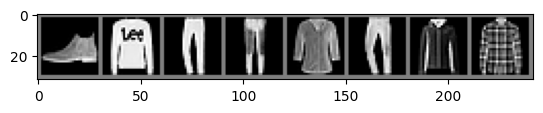

Real:      Ankle boot, Pullover, Trouser, Trouser, Shirt, Trouser, Coat, Shirt
Predicted: Sneaker, Pullover, Trouser, Trouser, Shirt, Trouser, Coat, Shirt


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Отримання передбачень
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Відображення зображень і передбачень
imshow(torchvision.utils.make_grid(images[:8].cpu()))
print('Real:     ', ', '.join(f'{classes[labels[j]]}' for j in range(8)))
print('Predicted:', ', '.join(f'{classes[predicted[j]]}' for j in range(8)))


In [13]:
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Вивід точності для кожного класу
for i in range(10):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

Accuracy of T-shirt/top: 66.50%
Accuracy of Trouser: 93.90%
Accuracy of Pullover: 70.10%
Accuracy of Dress: 91.40%
Accuracy of Coat: 76.70%
Accuracy of Sandal: 89.30%
Accuracy of Shirt: 49.20%
Accuracy of Sneaker: 95.70%
Accuracy of Bag: 95.10%
Accuracy of Ankle boot: 91.90%
